# Welcome to the Quantum Parallel Universe

## Initial Setup

### Immutable Imports

In [1]:
import math
import re
from IPython.display import Latex
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit import Qubit

### Globals

#### Manually Managed Variables & Imports

In [2]:
# number of qubits: int
N = 15

# IBMQ Mock Backend (https://qiskit.org/documentation/stable/0.42/apidoc/providers_fake_provider.html#fake-v1-backends)
from qiskit.providers.fake_provider import FakeCairo
backend = { 'device': FakeCairo() }

#### Automatically Managed Variables

In [3]:
# linear GHZ container
linear = {
  'circuit': None,
  'transpiled': None,
  'job': None,
  'result': None,
  'time': None,
  'error': { '0': None, '1': None }
}

# logarithmic GHZ container
log = {
  'circuit': None,
  'transpiled': None,
  'job': None,
  'result': None,
  'time': None,
  'error': { '0': None, '1': None }
}

# ideal shots per state
isps = 512

# parallel sections
init = [ 0, 1, 2 ]
i = len(init)
k = 1
while len(init) <= N:
  init += [i] * 2**k
  i += 1
  k += 1
s = init[N]

# IBMQ Mock Backend
if N > 0:
  backend['name'] = re.sub(r'(_|fake|v\d)', ' ', backend['device'].backend_name.lower()).title()
  backend['num_qubits'] = backend['device'].configuration().num_qubits
  backend['simulator'] = AerSimulator.from_backend(backend['device'])
else:
  raise RuntimeError(msg=f"Invalid N={N}, must be 0 < N < {backend['num_qubits']}")

---

## Generate $|\text{GHZ}_N\rangle$ Circuits<sup>1</sup>

### Generate Linear Time Complexity Circuits for $|\text{GHZ}_N\rangle$

In [4]:
def linear_complexity_GHZ(N: int) -> QuantumCircuit:
  if not isinstance(N, int):
    raise TypeError("Only integer arguments accepted.")
  if N < 1:
    raise ValueError("There must be one or more qubits.")

  c = QuantumCircuit(N)
  c.h(0)
  for i in range(1, N):
    c.cx(i-1, i)
  c.measure_active()
  return c

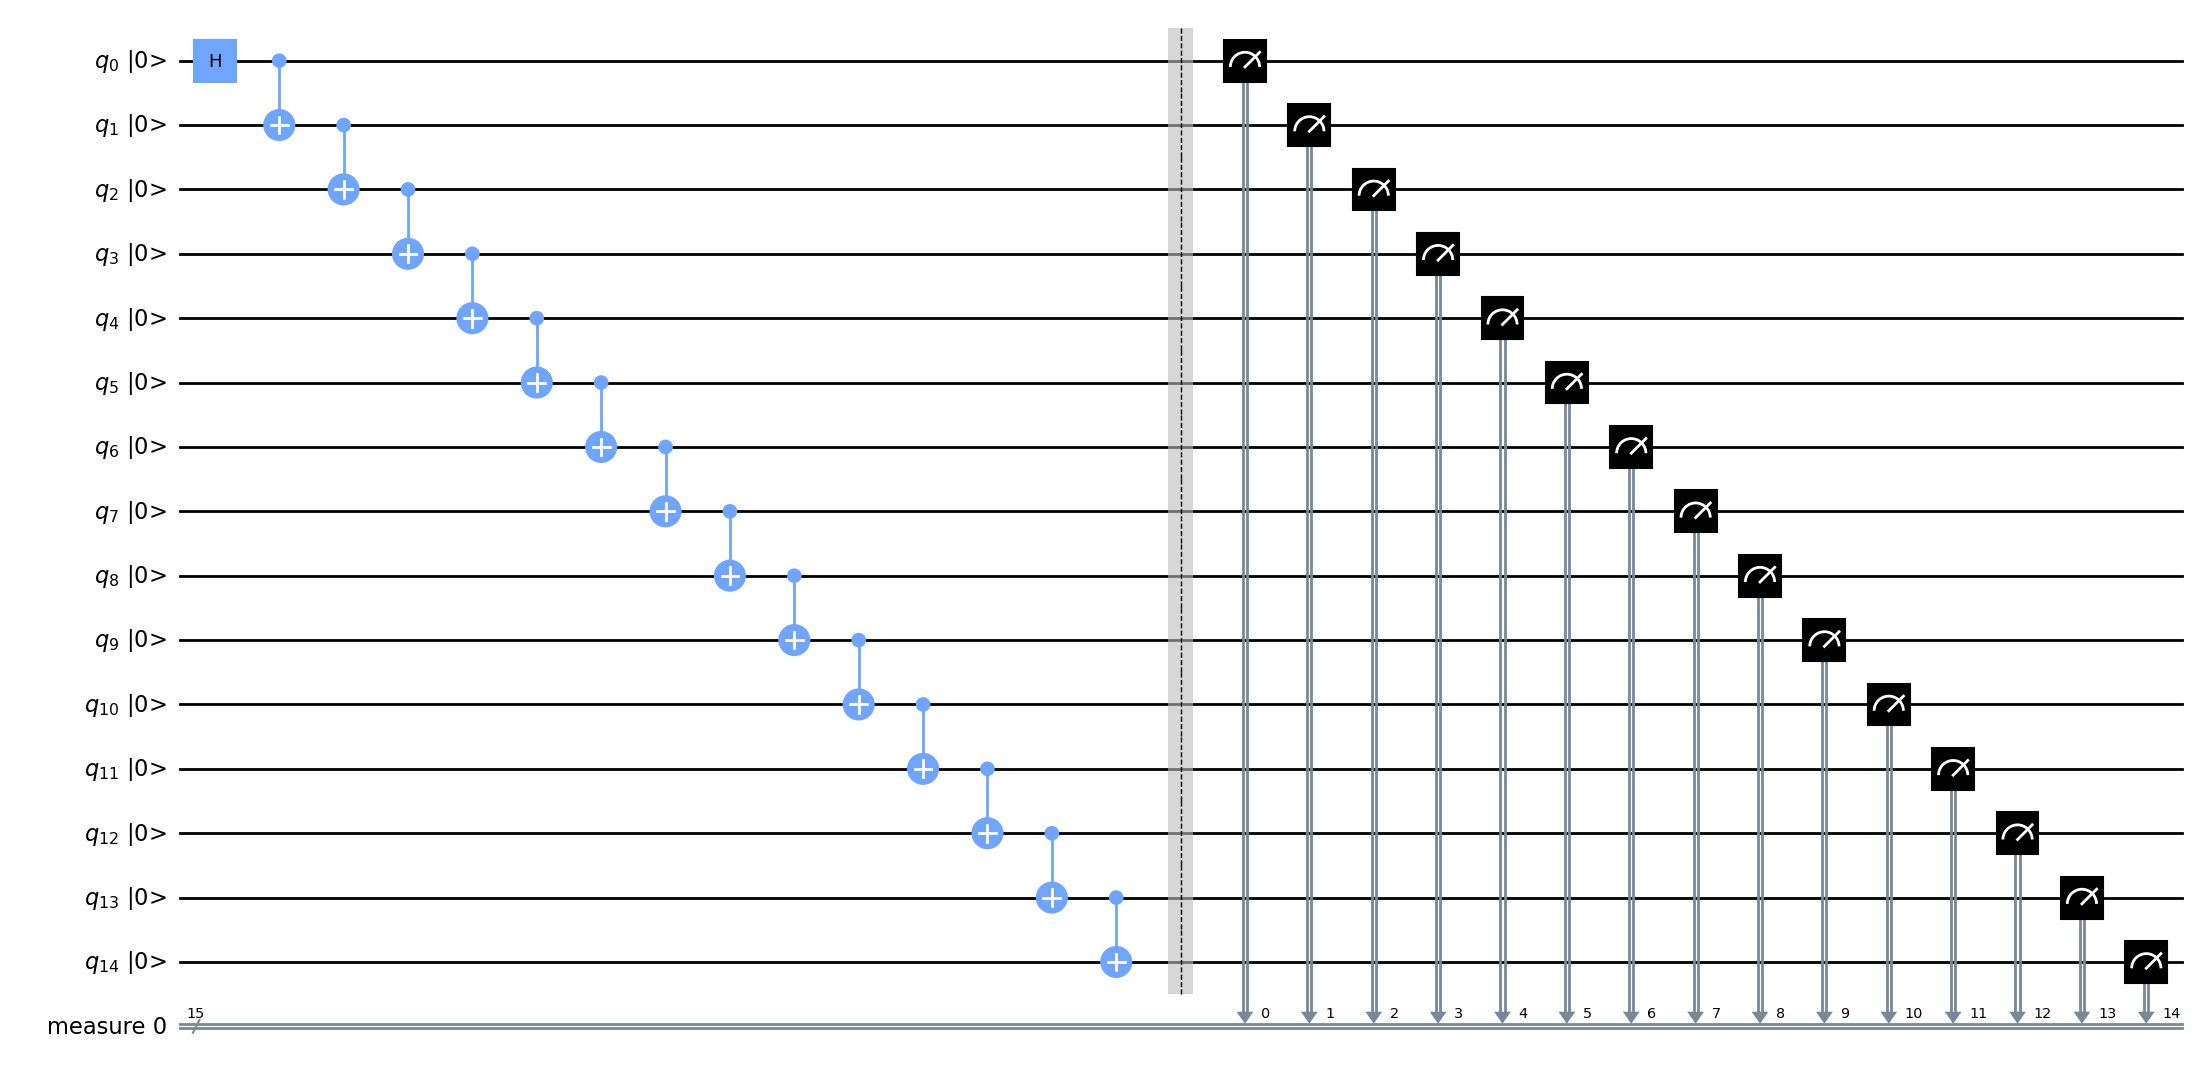

In [5]:
linear['circuit'] = linear_complexity_GHZ(N)
linear['circuit'].draw(output='mpl', fold=-1, initial_state=True)

### Generate Logaritmic Complexity Circuits for $|\text{GHZ}_{2^m}\rangle$

In [6]:
def _log_complexity_GHZ(m: int) -> QuantumCircuit:
  if not isinstance(m, int):
    raise TypeError("Only integer arguments accepted.")
  if m < 0:
    raise ValueError("`m` must be at least 0 (evaluated 2^m).")

  if m == 0:
    c = QuantumCircuit([Qubit()])
    c.h(0)
  else:
    c = _log_complexity_GHZ(m - 1)
    for i in range(c.num_qubits):
      c.add_bits([Qubit()])
      new_qubit_index = c.num_qubits - 1
      c.cx(i, new_qubit_index)
  return c

### Generate Logaritmic Complexity Circuits for $|\text{GHZ}_N\rangle$

In [7]:
def log_complexity_GHZ(N: int) -> QuantumCircuit:
  if not isinstance(N, int):
    raise TypeError("Only an integer argument is accepted.")
  if N < 1:
    raise ValueError("There must be one or more qubits.")

  m = math.ceil(math.log2(N))
  num_qubits_to_erase = 2**m - N
  old_circuit = _log_complexity_GHZ(m=m)
  new_num_qubits = old_circuit.num_qubits - num_qubits_to_erase
  new_circuit = QuantumCircuit(new_num_qubits)
  for gate in old_circuit.data:
    qubits_affected = gate.qubits
    if all(old_circuit.find_bit(qubit).index < new_num_qubits for qubit in qubits_affected):
      new_circuit.append(gate[0], [old_circuit.find_bit(qubit).index for qubit in qubits_affected])
  new_circuit.measure_active()
  return new_circuit


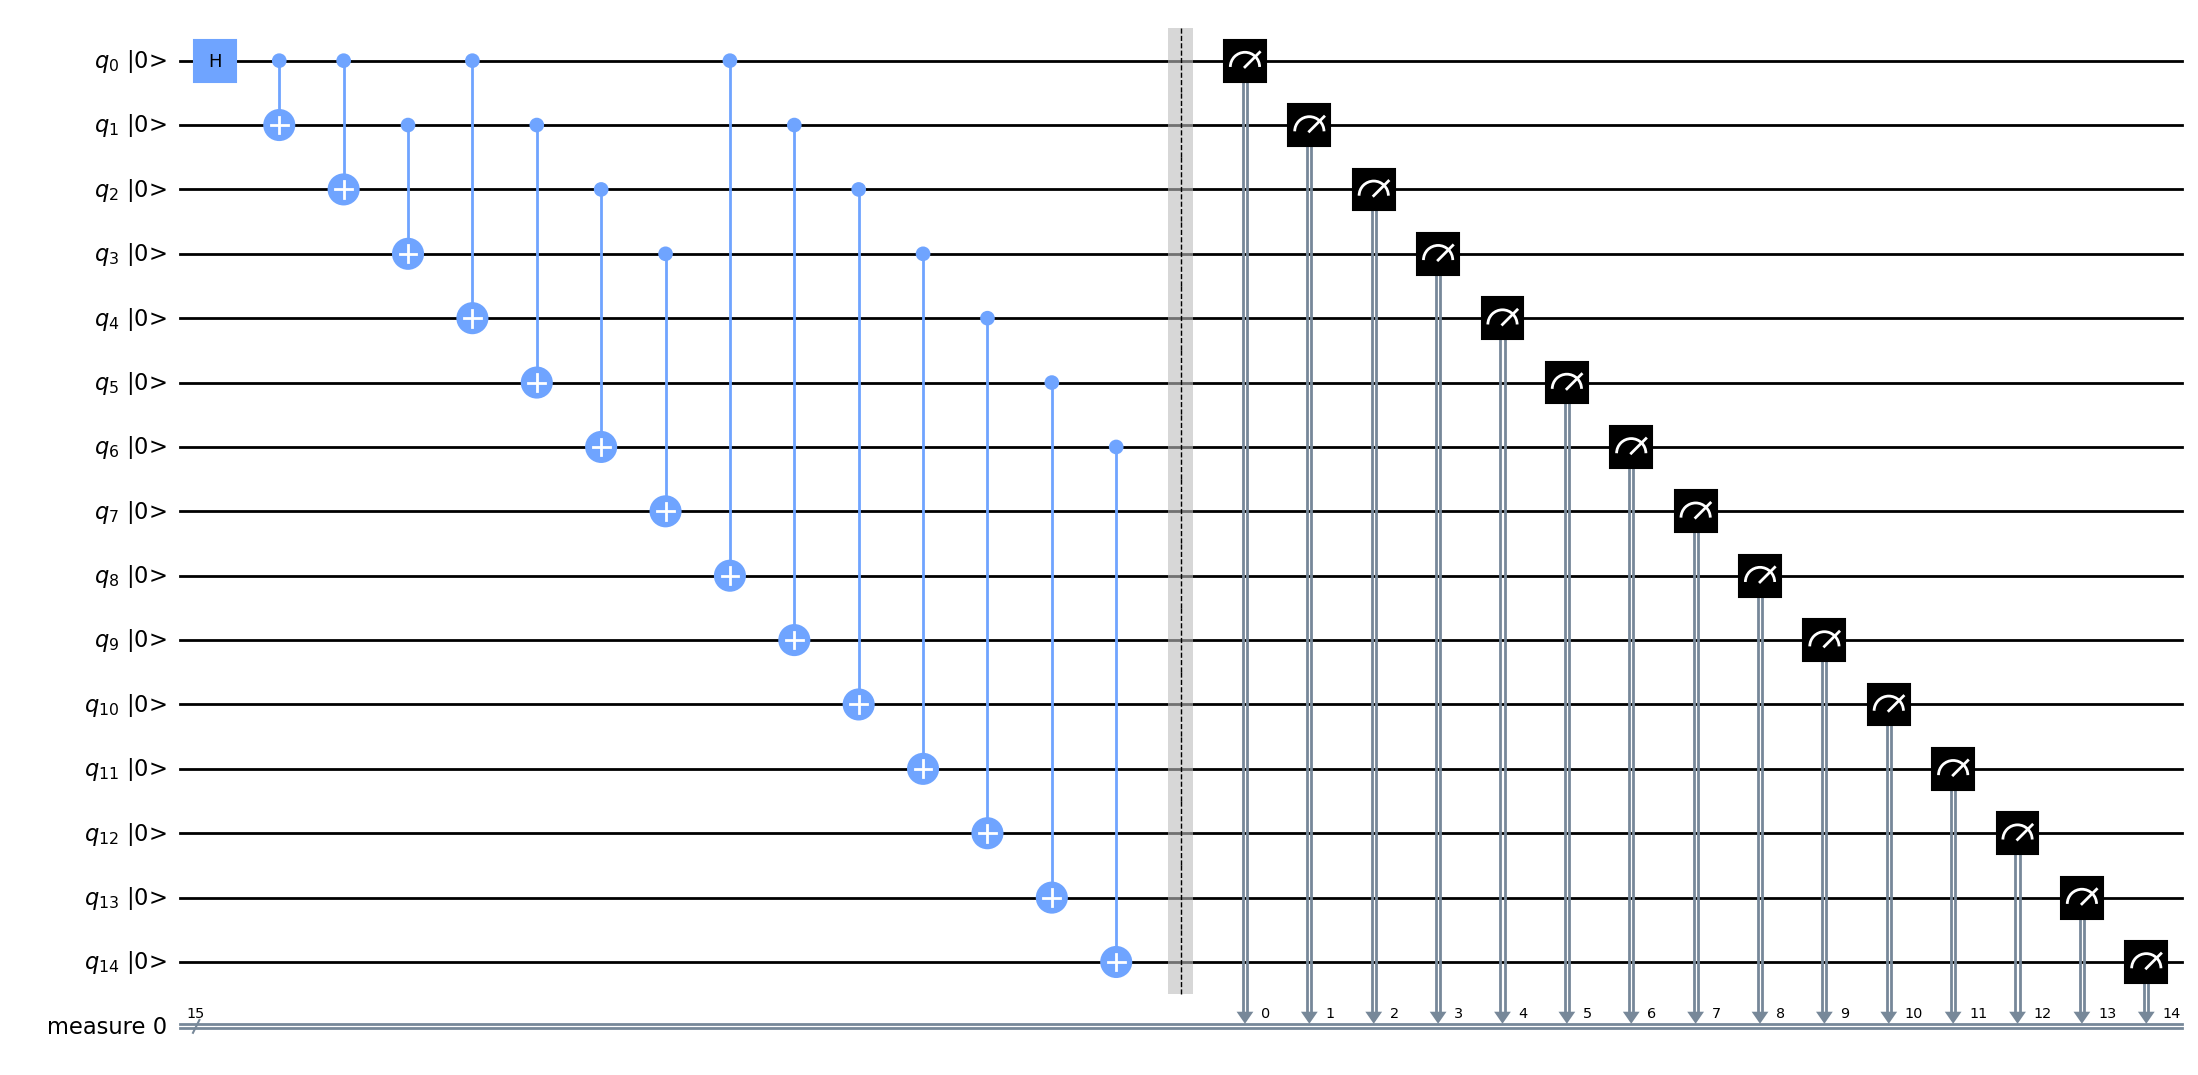

In [8]:
log['circuit'] = log_complexity_GHZ(N)
log['circuit'].draw(output='mpl', fold=-1, initial_state=True)

---

## Quantum Simulation

### Device

In [9]:
Latex(f"""\\begin{{equation*}}
          \\text{{{backend['name']} ({backend['num_qubits']} qubits)}}
          \\end{{equation*}}""")

<IPython.core.display.Latex object>

### Transpile Circuits

In [10]:
linear['transpiled'] = transpile(linear['circuit'], backend['simulator'], scheduling_method="asap", optimization_level=0)

In [11]:
log['transpiled'] = transpile(log['circuit'], backend['simulator'], scheduling_method="asap", optimization_level=0)

### Run Simulations

In [12]:
linear['job'] = backend['device'].run(linear['transpiled'])

In [13]:
log['job'] = backend['device'].run(log['transpiled'])

### Block for Results

In [14]:
linear['result'] = linear['job'].result()

In [15]:
log['result'] = log['job'].result()

---

## Error Analysis

### Linear Error Percentage

##### State $|0\rangle$

In [16]:
try:
  linear['error']['0'] = abs((linear['result'].get_counts()['0' * N] - isps) / isps)
except KeyError:
  linear['error']['0'] = 1
Latex(f"""\\begin{{equation*}}{linear['error']['0'] * 100}\%\\end{{equation*}}""")


<IPython.core.display.Latex object>

##### State $|1\rangle$

In [17]:
try:
  linear['error']['1'] = abs((linear['result'].get_counts()['1' * N] - isps) / isps)
except KeyError:
  linear['error']['1'] = 1
Latex(f"""\\begin{{equation*}}{linear['error']['1'] * 100}\%\\end{{equation*}}""")

<IPython.core.display.Latex object>

### Logarithmic Error Percentage

#### State $|0\rangle$

In [18]:
try:
  log['error']['0'] = abs((log['result'].get_counts()['0' * N] - isps) / isps)
except KeyError:
  log['error']['0'] = 1
Latex(f"""\\begin{{equation*}}{log['error']['0'] * 100}\%\\end{{equation*}}""")

<IPython.core.display.Latex object>

#### State $|1\rangle$

In [19]:
try:
  log['error']['1'] = abs((log['result'].get_counts()['1' * N] - isps) / isps)
except KeyError:
  log['error']['1'] = 1
Latex(f"""\\begin{{equation*}}{log['error']['1'] * 100}\%\\end{{equation*}}""")

<IPython.core.display.Latex object>

---

## Speed-Up Analysis

### Run-Times

#### Linear

In [20]:
linear['time'] = linear['result'].time_taken
Latex(f"""\\begin{{equation*}}{linear['time']}\\space\\text{{seconds}}\\end{{equation*}}""")

<IPython.core.display.Latex object>

#### Log

In [21]:
log['time'] = log['result'].time_taken
Latex(f"""\\begin{{equation*}}{log['time']}\\space\\text{{seconds}}\\end{{equation*}}""")

<IPython.core.display.Latex object>

### Amdahl's Law

#### Parallel Portion

In [22]:
S_latency = linear['time'] / log['time']
P = (N * (1 - (1 / S_latency))) / (N - 1)
Latex(f"""\\begin{{equation*}}
    P = \\dfrac{{s\\left(1 - \\dfrac{{1}}{{S_\\text{{latency}}}}\\right)}}{{s - 1}} = \\dfrac{{{s}\\left(1 - \\dfrac{{1}}{{{S_latency}}}\\right)}}{{{s - 1}}} = {P * 100}\%
    \\end{{equation*}}
  """)

<IPython.core.display.Latex object>

#### Sequential Portion

In [23]:
S_EQ = 1 - P
Latex(f"""\\begin{{equation*}}S_\\text{{EQ}} = 1 - P = {S_EQ * 100}\%\\end{{equation*}}""")

<IPython.core.display.Latex object>

---

## References

1. [Cruz, Diogo, Romain Fournier, Fabien Gremion, Alix Jeannerot, Kenichi Komagata, Tara Tosic, Jarla Thiesbrummel, et al. (2018). Efficient Quantum Algorithms for $GHZ$ and $W$ States, and Implementation on the IBM Quantum Computer. ArXiv.](https://doi.org/10.48550/ARXIV.1807.05572)